In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V2.csv")

In [3]:
df.describe()

,Energy_Unit,Energy_density_Joule,Volume_m3,Event_freq_unit_per_day,Energy_Joule_per_day,Volume_m3_per_day,Duration_days,Intensity_Level_encoded,Energy_per_Volume,Energy_Unit_log,Energy_density_Joule_sqr,Volume_m3_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,12.010989,4.354509,4.133324,1.578603,3.535533,3.315526,7.668132,1.142857,2.723629,2.195445,20.997179,17.504189,0.848553,14.243304,11.328232,1.137762
std,11.922429,1.434590,0.651525,1.287998,1.327660,0.582447,4.152453,1.060099,2.422837,0.881149,10.887185,5.169944,0.430042,8.317308,3.639632,0.585798
min,1.000000,0.780000,2.712600,0.161400,0.290500,1.678600,1.000000,0.000000,0.232019,0.693147,0.608400,7.358199,0.149626,0.084390,2.817698,0.208654
25%,3.500000,3.781000,3.718000,0.725000,2.870500,2.956500,4.000000,0.000000,0.854513,1.497866,14.306162,13.823624,0.545122,8.239902,8.740949,0.617543
50%,8.000000,4.614000,4.238000,1.222000,3.739000,3.474000,7.000000,1.000000,2.168727,2.197225,21.288996,17.960644,0.798408,13.980121,12.068676,1.153330
75%,17.000000,5.311000,4.643500,2.000000,4.575000,3.724500,10.000000,2.000000,3.603378,2.890372,28.206842,21.562365,1.098612,20.931354,13.872362,1.526582
max,49.000000,6.466100,5.102300,5.897500,5.645000,4.218100,16.600000,3.000000,9.849246,3.912023,41.810449,26.033465,1.931159,31.866025,17.792368,2.384096


## Using SMOTE to balance the data

In [4]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data
X = df.drop(columns=['Intensity_Level_encoded',"Intensity_Level"])
y = df['Intensity_Level_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Applying SMOTE on train set only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Intensity_Level_encoded
0    27
2    20
1    16
3     9
Name: count, dtype: int64
After SMOTE: Intensity_Level_encoded
0    27
3    27
2    27
1    27
Name: count, dtype: int64


c:\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\subprocess.py",

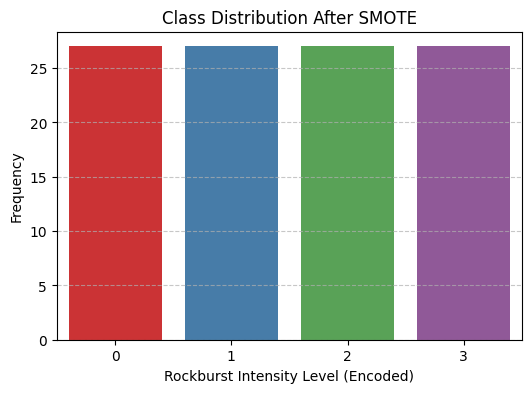

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, palette="Set1",hue=y_train_res,legend=False)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Noise Injection To increase the samples

In [6]:
# Function to add noise
def add_noise(data, noise_factor=0.01):
    noisy_data = data.copy()
    for col in noisy_data.columns:
        if np.issubdtype(noisy_data[col].dtype, np.number):
            std_dev = noisy_data[col].std()
            noise = np.random.normal(0, std_dev * noise_factor, size=noisy_data[col].shape)
            noisy_data[col] = noisy_data[col] + noise
    return noisy_data


In [7]:
target_size = 1000
augmented_X = [X_train_res]
augmented_y = [y_train_res]

while len(pd.concat(augmented_X)) < target_size:
    X_noisy = add_noise(X_train_res, noise_factor=0.01)
    augmented_X.append(X_noisy)
    augmented_y.append(y_train_res)  # Labels same rahenge

# --- Step 4: Final Dataset ---
final_X_train = pd.concat(augmented_X).reset_index(drop=True)
final_y_train = pd.concat(augmented_y).reset_index(drop=True)

# Agar size exact 1000 chahiye
final_X_train = final_X_train.iloc[:target_size]
final_y_train = final_y_train.iloc[:target_size]

print("Final Train Size:", len(final_X_train))
print(final_y_train.value_counts())

Final Train Size: 1000
Intensity_Level_encoded
0    254
1    250
3    248
2    248
Name: count, dtype: int64


In [8]:
df=pd.concat([final_X_train,final_y_train],axis=1)

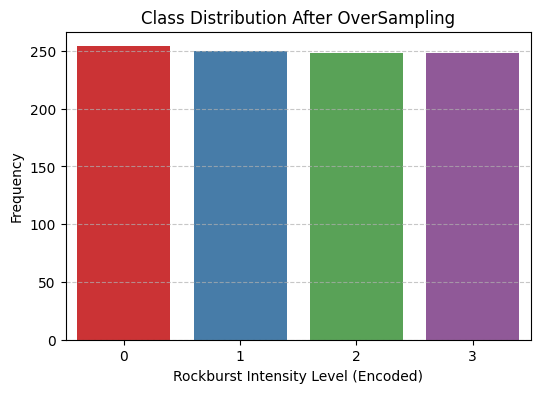

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=final_y_train, palette="Set1",hue=final_y_train,legend=False)
plt.title("Class Distribution After OverSampling")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [10]:
df.head()

,Energy_Unit,Energy_density_Joule,Volume_m3,Event_freq_unit_per_day,Energy_Joule_per_day,Volume_m3_per_day,Duration_days,Energy_per_Volume,Energy_Unit_log,Energy_density_Joule_sqr,Volume_m3_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Intensity_Level_encoded
0,1.0,1.540,4.310,1.000,1.540,4.2181,1.0,0.232019,0.693147,2.371600,18.576100,0.693147,2.371600,17.792368,0.208654,0
1,1.0,4.780,2.985,1.000,4.780,2.9850,1.0,0.335008,0.693147,22.848400,8.910225,0.693147,22.848400,8.910225,0.288938,0
2,29.0,5.513,4.777,5.800,4.814,4.0780,5.0,6.070756,3.401197,30.393169,22.819729,1.916923,23.174596,16.630084,1.955967,3
3,5.0,2.435,3.878,0.455,1.393,2.8360,11.0,1.289324,1.791759,5.929225,15.038884,0.375006,1.940449,8.042896,0.828257,0
4,14.0,4.818,4.266,1.273,3.776,3.2250,11.0,3.281763,2.708050,23.213124,18.198756,0.821101,14.258176,10.400625,1.454365,2


In [12]:
train_df=df.drop(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 
       'Volume_m3_per_day','Energy_per_Volume'],axis=1)

In [13]:
train_df.head()

,Duration_days,Energy_Unit_log,Energy_density_Joule_sqr,Volume_m3_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Intensity_Level_encoded
0,1.0,0.693147,2.371600,18.576100,0.693147,2.371600,17.792368,0.208654,0
1,1.0,0.693147,22.848400,8.910225,0.693147,22.848400,8.910225,0.288938,0
2,5.0,3.401197,30.393169,22.819729,1.916923,23.174596,16.630084,1.955967,3
3,11.0,1.791759,5.929225,15.038884,0.375006,1.940449,8.042896,0.828257,0
4,11.0,2.708050,23.213124,18.198756,0.821101,14.258176,10.400625,1.454365,2


In [14]:
train_df.describe()

,Duration_days,Energy_Unit_log,Energy_density_Joule_sqr,Volume_m3_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Intensity_Level_encoded
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.466166,2.451214,24.528511,18.813178,0.944573,16.792005,12.029246,1.303947,1.490000
std,4.053318,0.900045,10.572402,4.948378,0.427540,8.159892,3.384080,0.616659,1.120337
min,0.913154,0.671321,0.533291,7.275531,0.144454,-0.167557,2.767655,0.200322,0.000000
25%,5.066297,1.799373,19.271873,15.105369,0.689051,11.993027,9.681555,0.831573,0.000000
50%,8.830382,2.473346,23.586512,19.285100,0.888821,16.224897,12.836993,1.286023,1.000000
75%,10.915463,3.133383,33.485338,22.888978,1.208827,23.520190,14.282274,1.715136,2.000000
max,16.688039,3.930137,42.023571,26.140775,1.938654,32.033348,17.831270,2.391327,3.000000


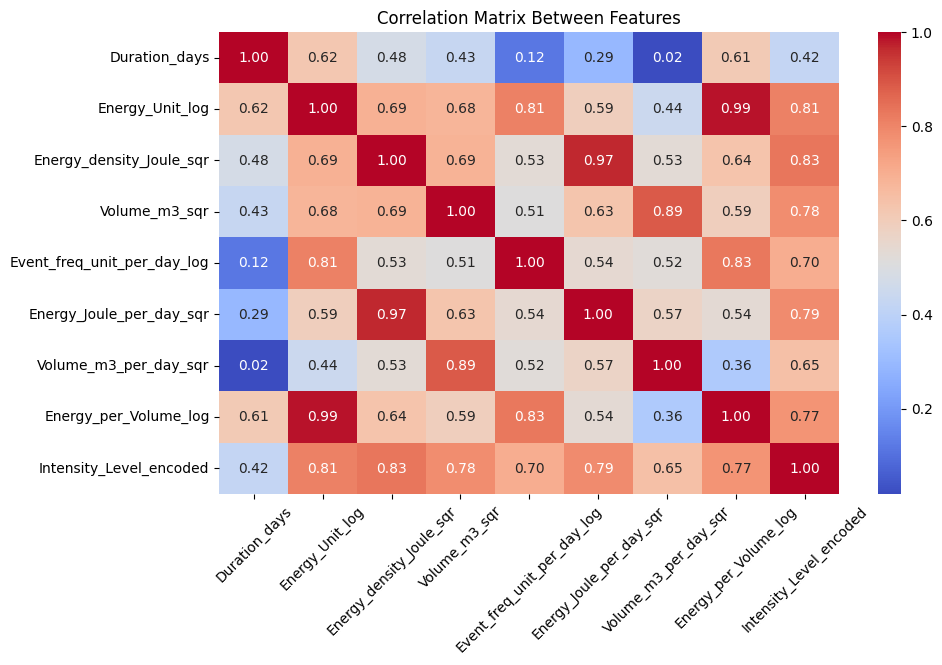

In [15]:
columns=train_df.columns
plt.figure(figsize=(10,6))
sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Between Features")
plt.xticks(rotation=45)
plt.show()


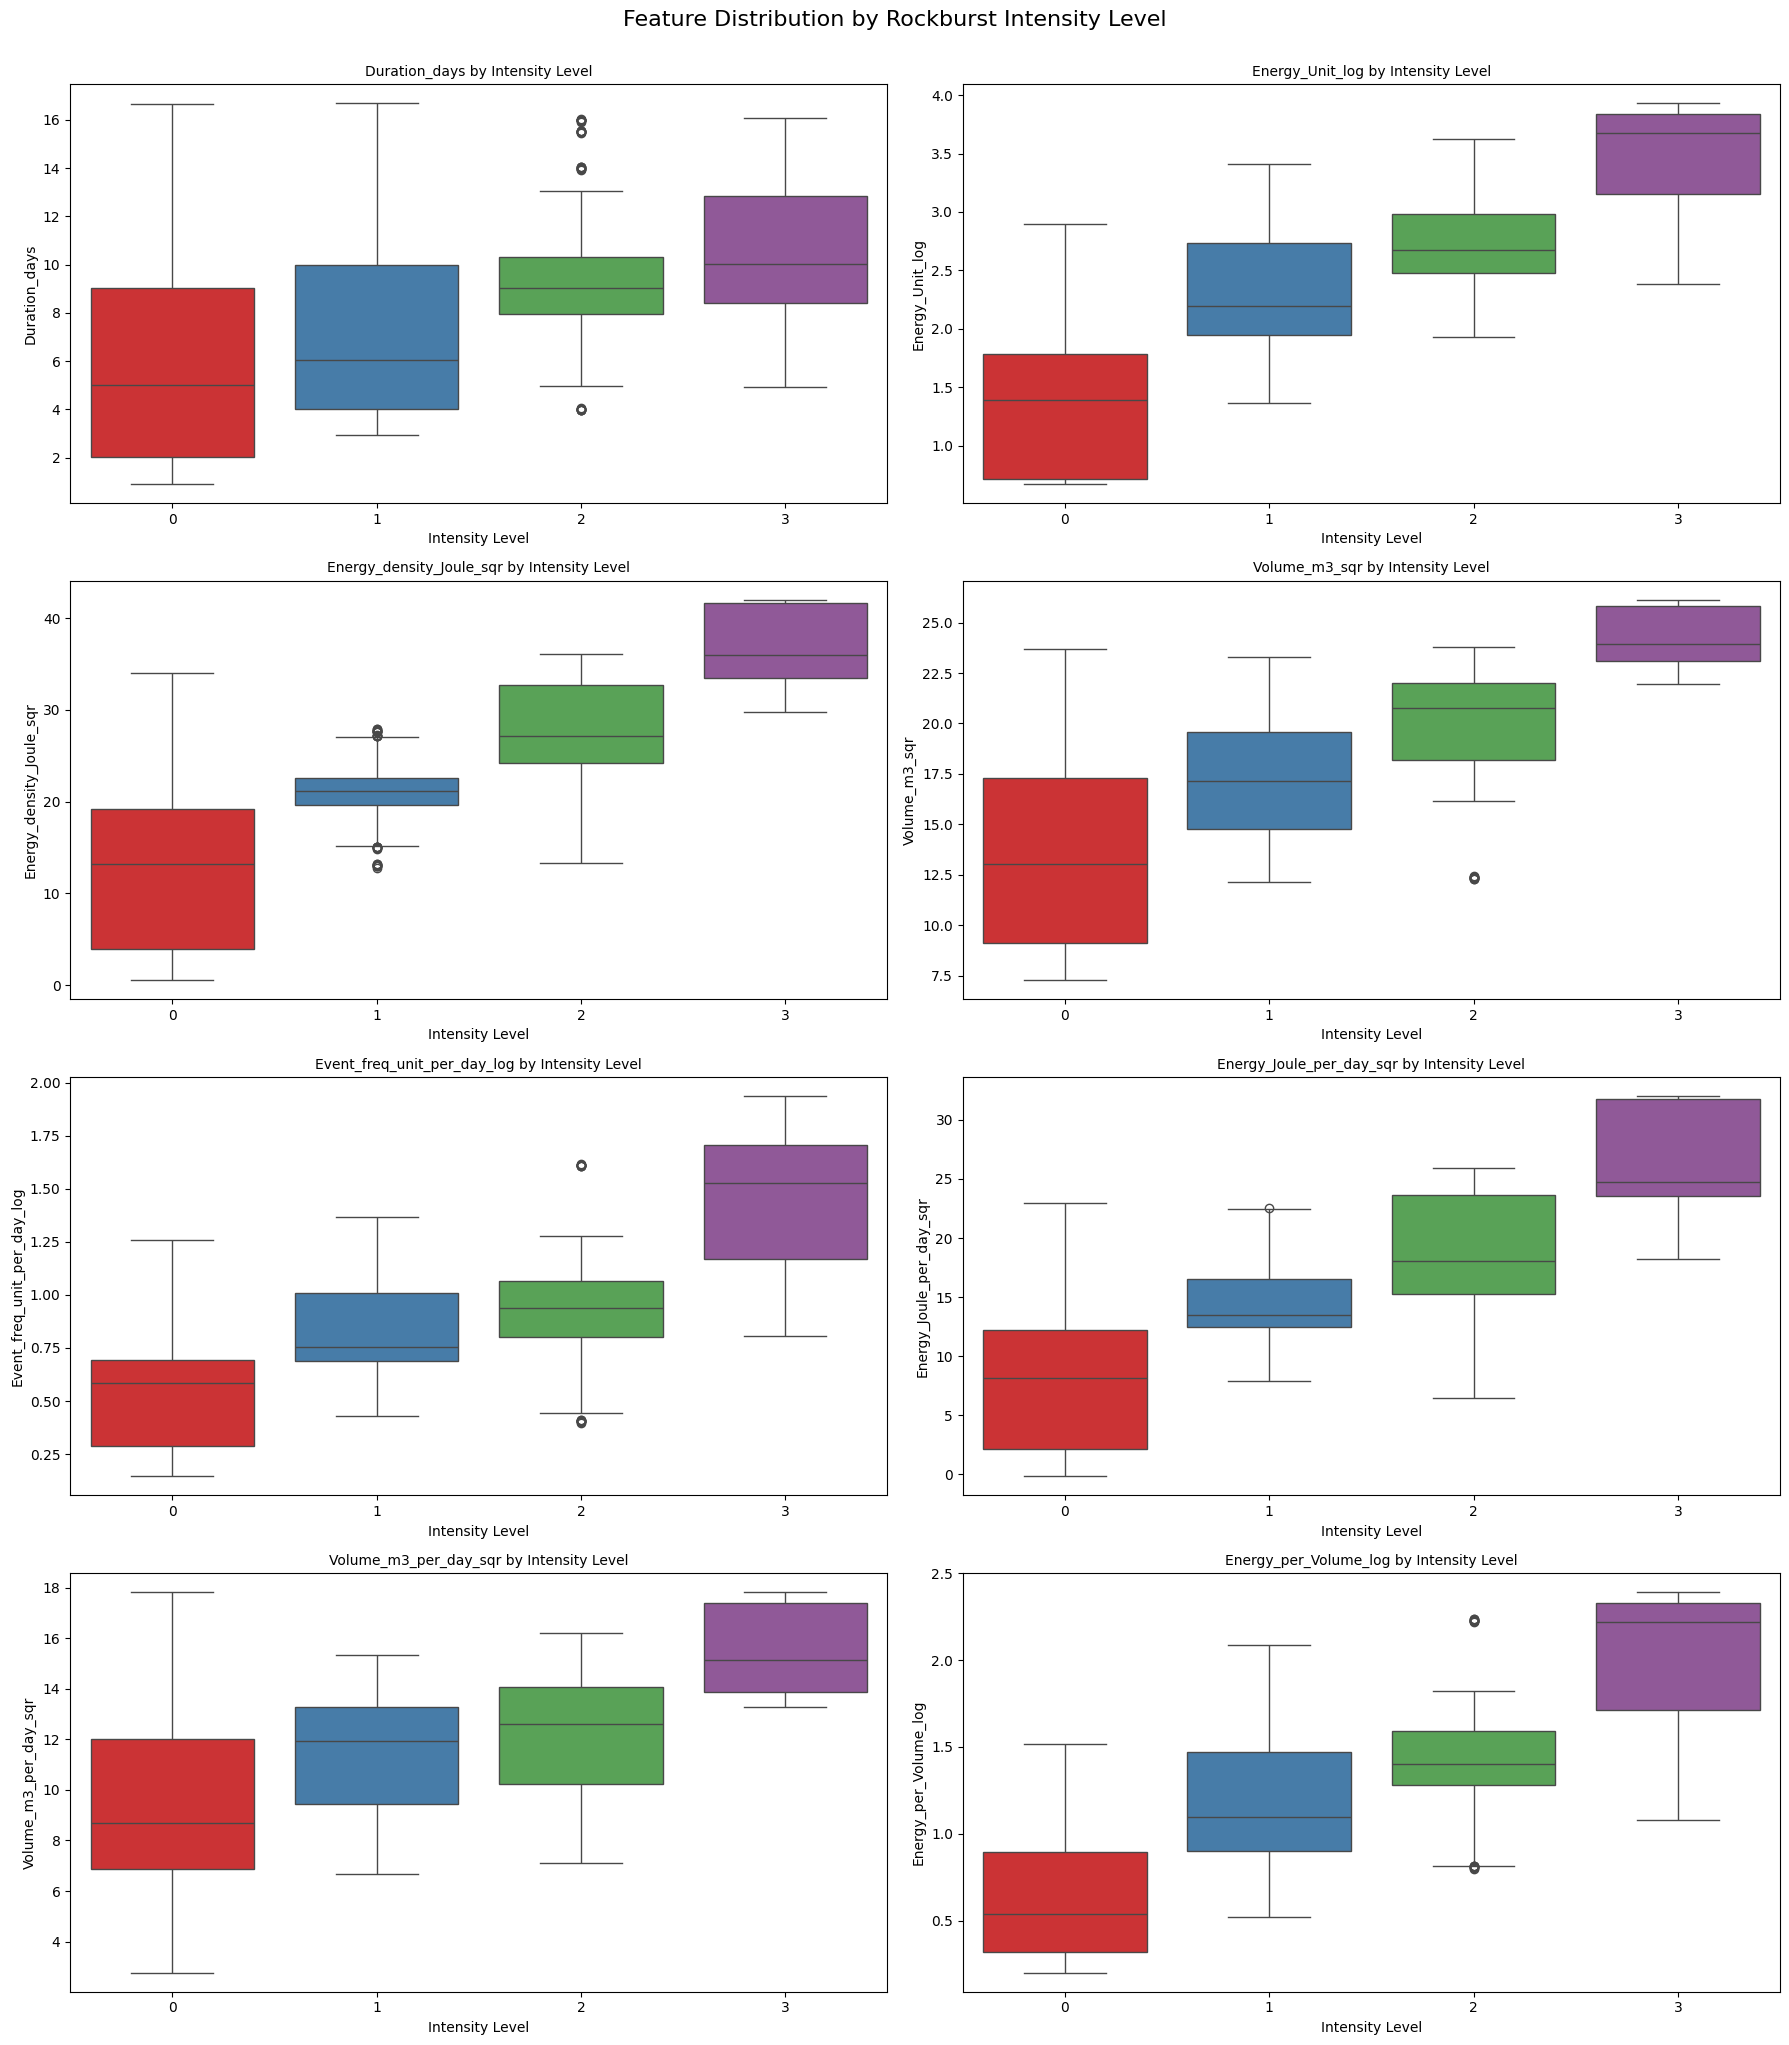

In [16]:
features = [col for col in train_df.columns if col not in ['Intensity_Level_encoded']]
n_features = len(features)

n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='Intensity_Level_encoded', y=feature, data=train_df, palette='Set1', ax=axes[i],hue="Intensity_Level_encoded",legend=False)
    axes[i].set_title(f"{feature} by Intensity Level", fontsize=10)
    axes[i].set_xlabel("Intensity Level")
    axes[i].set_ylabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Feature Distribution by Rockburst Intensity Level", fontsize=16, y=1.02)
plt.show()

In [17]:
train_df.to_csv("Data/Preprocessed/Rockburst_in_Tunnel_V3.csv")

In [18]:
train_df.describe()

,Duration_days,Energy_Unit_log,Energy_density_Joule_sqr,Volume_m3_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Intensity_Level_encoded
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.466166,2.451214,24.528511,18.813178,0.944573,16.792005,12.029246,1.303947,1.490000
std,4.053318,0.900045,10.572402,4.948378,0.427540,8.159892,3.384080,0.616659,1.120337
min,0.913154,0.671321,0.533291,7.275531,0.144454,-0.167557,2.767655,0.200322,0.000000
25%,5.066297,1.799373,19.271873,15.105369,0.689051,11.993027,9.681555,0.831573,0.000000
50%,8.830382,2.473346,23.586512,19.285100,0.888821,16.224897,12.836993,1.286023,1.000000
75%,10.915463,3.133383,33.485338,22.888978,1.208827,23.520190,14.282274,1.715136,2.000000
max,16.688039,3.930137,42.023571,26.140775,1.938654,32.033348,17.831270,2.391327,3.000000


In [19]:
test_df=pd.concat([X_test,y_test],axis=1)

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 85 to 64
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Energy_Unit                  19 non-null     int64  
 1   Energy_density_Joule         19 non-null     float64
 2   Volume_m3                    19 non-null     float64
 3   Event_freq_unit_per_day      19 non-null     float64
 4   Energy_Joule_per_day         19 non-null     float64
 5   Volume_m3_per_day            19 non-null     float64
 6   Duration_days                19 non-null     float64
 7   Energy_per_Volume            19 non-null     float64
 8   Energy_Unit_log              19 non-null     float64
 9   Energy_density_Joule_sqr     19 non-null     float64
 10  Volume_m3_sqr                19 non-null     float64
 11  Event_freq_unit_per_day_log  19 non-null     float64
 12  Energy_Joule_per_day_sqr     19 non-null     float64
 13  Volume_m3_per_day_sqr     

In [21]:
test_df.drop(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 
       'Volume_m3_per_day','Energy_per_Volume'],axis=1,inplace=True)

In [22]:
test_df.head()

,Duration_days,Energy_Unit_log,Energy_density_Joule_sqr,Volume_m3_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Intensity_Level_encoded
85,5.0,2.484907,16.892100,13.133376,1.163151,11.634921,8.555625,1.395086,3
90,4.0,1.945910,28.090000,7.480225,0.916291,22.071204,4.549689,1.161207,0
74,13.0,2.197225,17.073424,12.278016,0.479335,9.108324,5.712100,1.188790,1
69,7.0,1.386294,25.603600,19.695844,0.356975,17.766225,12.909649,0.516398,2
2,9.0,2.890372,22.600516,19.333609,1.060910,14.440000,11.854249,1.582328,2


In [23]:
test_df.to_csv("Data/Preprocessed/Rockburst_test_data.csv",index=False)